In [1]:
import sys
sys.path.append('../')
from utilities import *
import utilities

In [25]:
mean, std = get_mean_and_std(224)
print(f'Mean: {mean}')
print(f'Std Dev: {std}')

Mean: tensor([0.3282, 0.3282, 0.3281])
Std Dev: tensor([0.2194, 0.2194, 0.2194])


In [38]:
patch_size = 16         # Patch size (P) = 16
latent_size = 768       # Latent vector (D). ViT-Base uses 768
n_channels = 3          # Number of channels for input images
num_heads = 12          # ViT-Base uses 12 heads
num_encoders = 12       # ViT-Base uses 12 encoder layers
dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
num_classes = 3        # Number of classes in Busi dataset
size = 224              # Size used for training = 224

epochs = 2             # Number of epochs
base_lr = 1e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)
batch_size = 32

In [45]:
# Define transformations for the training data
transform_training_data = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.GaussianBlur(3),
    ToTensor(),
    Normalize(mean, std)
])

# Define the transformations for validation data (no augmentation, only necessary processing)
transform_validation_data = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean, std)
])

train_loader, val_loader = get_train_and_validation_loader(transform_training_data, transform_validation_data, batch_size=batch_size)

In [46]:
# Model components
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_size=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_size = embed_size

        self.num_patches = (img_size // patch_size) ** 2
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, embed_size, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_size))
        self.positions = nn.Parameter(torch.zeros(1, 1 + self.num_patches, embed_size))

    def forward(self, x):
        b = x.shape[0]
        x = self.projection(x)  # Shape: (B, E, N)
        x = x.transpose(1, 2)  # Shape: (B, N, E)
        cls_token = self.cls_token.expand(b, -1, -1)  # Expand cls token for batch
        x = torch.cat([cls_token, x], dim=1)  # Add cls token
        x += self.positions
        return x

In [48]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_size=768, num_heads=12, dropout=0.1, forward_expansion=4):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(forward_expansion * embed_size, embed_size),
            nn.Dropout(dropout)
        )

    def forward(self, value):
        attention_out, _ = self.attention(value, value, value)
        query = self.norm1(value + attention_out)
        forward_out = self.feed_forward(query)
        out = self.norm2(query + forward_out)
        return out

In [49]:
class ViT(nn.Module):
    def __init__(self, num_classes=3, num_encoders=12, img_size=224, patch_size=16, in_channels=3, embed_size=768, num_heads=12, dropout=0.1, forward_expansion=4):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_size)
        self.encoders = nn.ModuleList([
            TransformerEncoder(embed_size, num_heads, dropout, forward_expansion) for _ in range(num_encoders)
        ])
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        for encoder in self.encoders:
            x = encoder(x)
        x = self.to_cls_token(x[:, 0])  # Extract the class token
        return self.mlp_head(x)

In [50]:
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1/2
Training: Loss: 2.5142 | Acc: 47.44% | F1: 0.43 | Precision: 0.41 | Recall: 0.47
Validation: Loss: 1.0350 | Acc: 55.13% | F1: 0.39 | Precision: 0.75 | Recall: 0.55


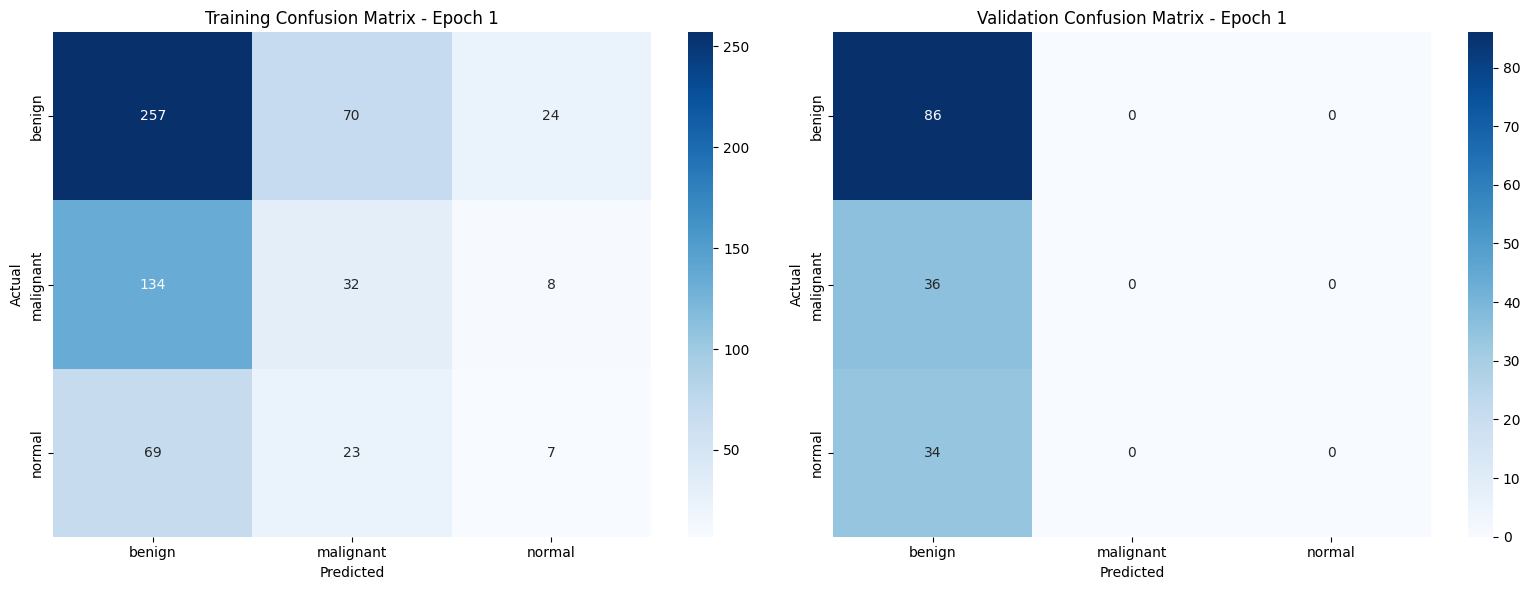


------------------------------------------------------------------------------------------------------------------



Training Batch:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 2/2
Training: Loss: 1.0452 | Acc: 49.20% | F1: 0.42 | Precision: 0.41 | Recall: 0.49
Validation: Loss: 1.0405 | Acc: 55.13% | F1: 0.39 | Precision: 0.75 | Recall: 0.55


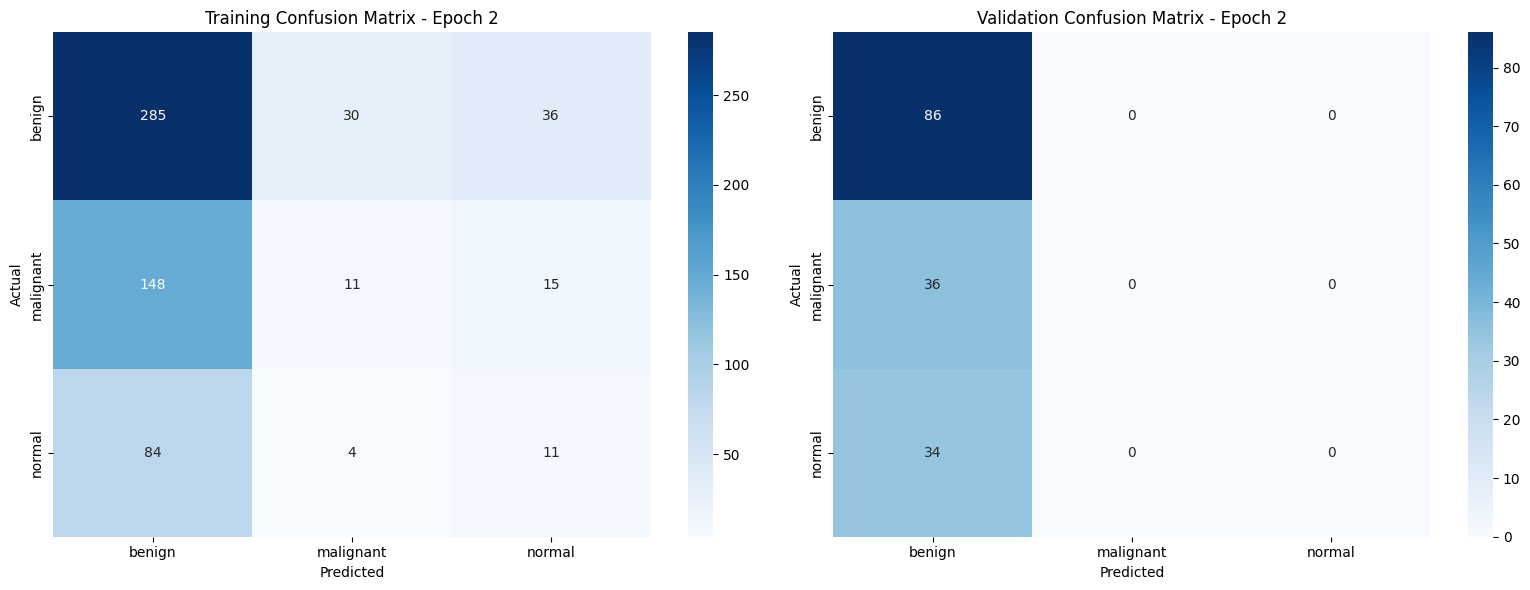


------------------------------------------------------------------------------------------------------------------



In [51]:
train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores, train_recalls, val_recalls, train_precisions, val_precisions, train_conf_matrices, val_conf_matrices, all_train_labels, all_train_probs, all_val_labels, all_val_probs = vit_train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device)

In [17]:
save_model(model, './models/vit-impl-3.pth')

Model saved to /content/drive/MyDrive/LU_ML MS thesis/Project/vit/models/vit-3.pth.
Model loaded from /content/drive/MyDrive/LU_ML MS thesis/Project/vit/models/vit-3.pth.


In [ ]:
model = ViT().to(device)
load_model(model, './models/vit-impl-3.pth')

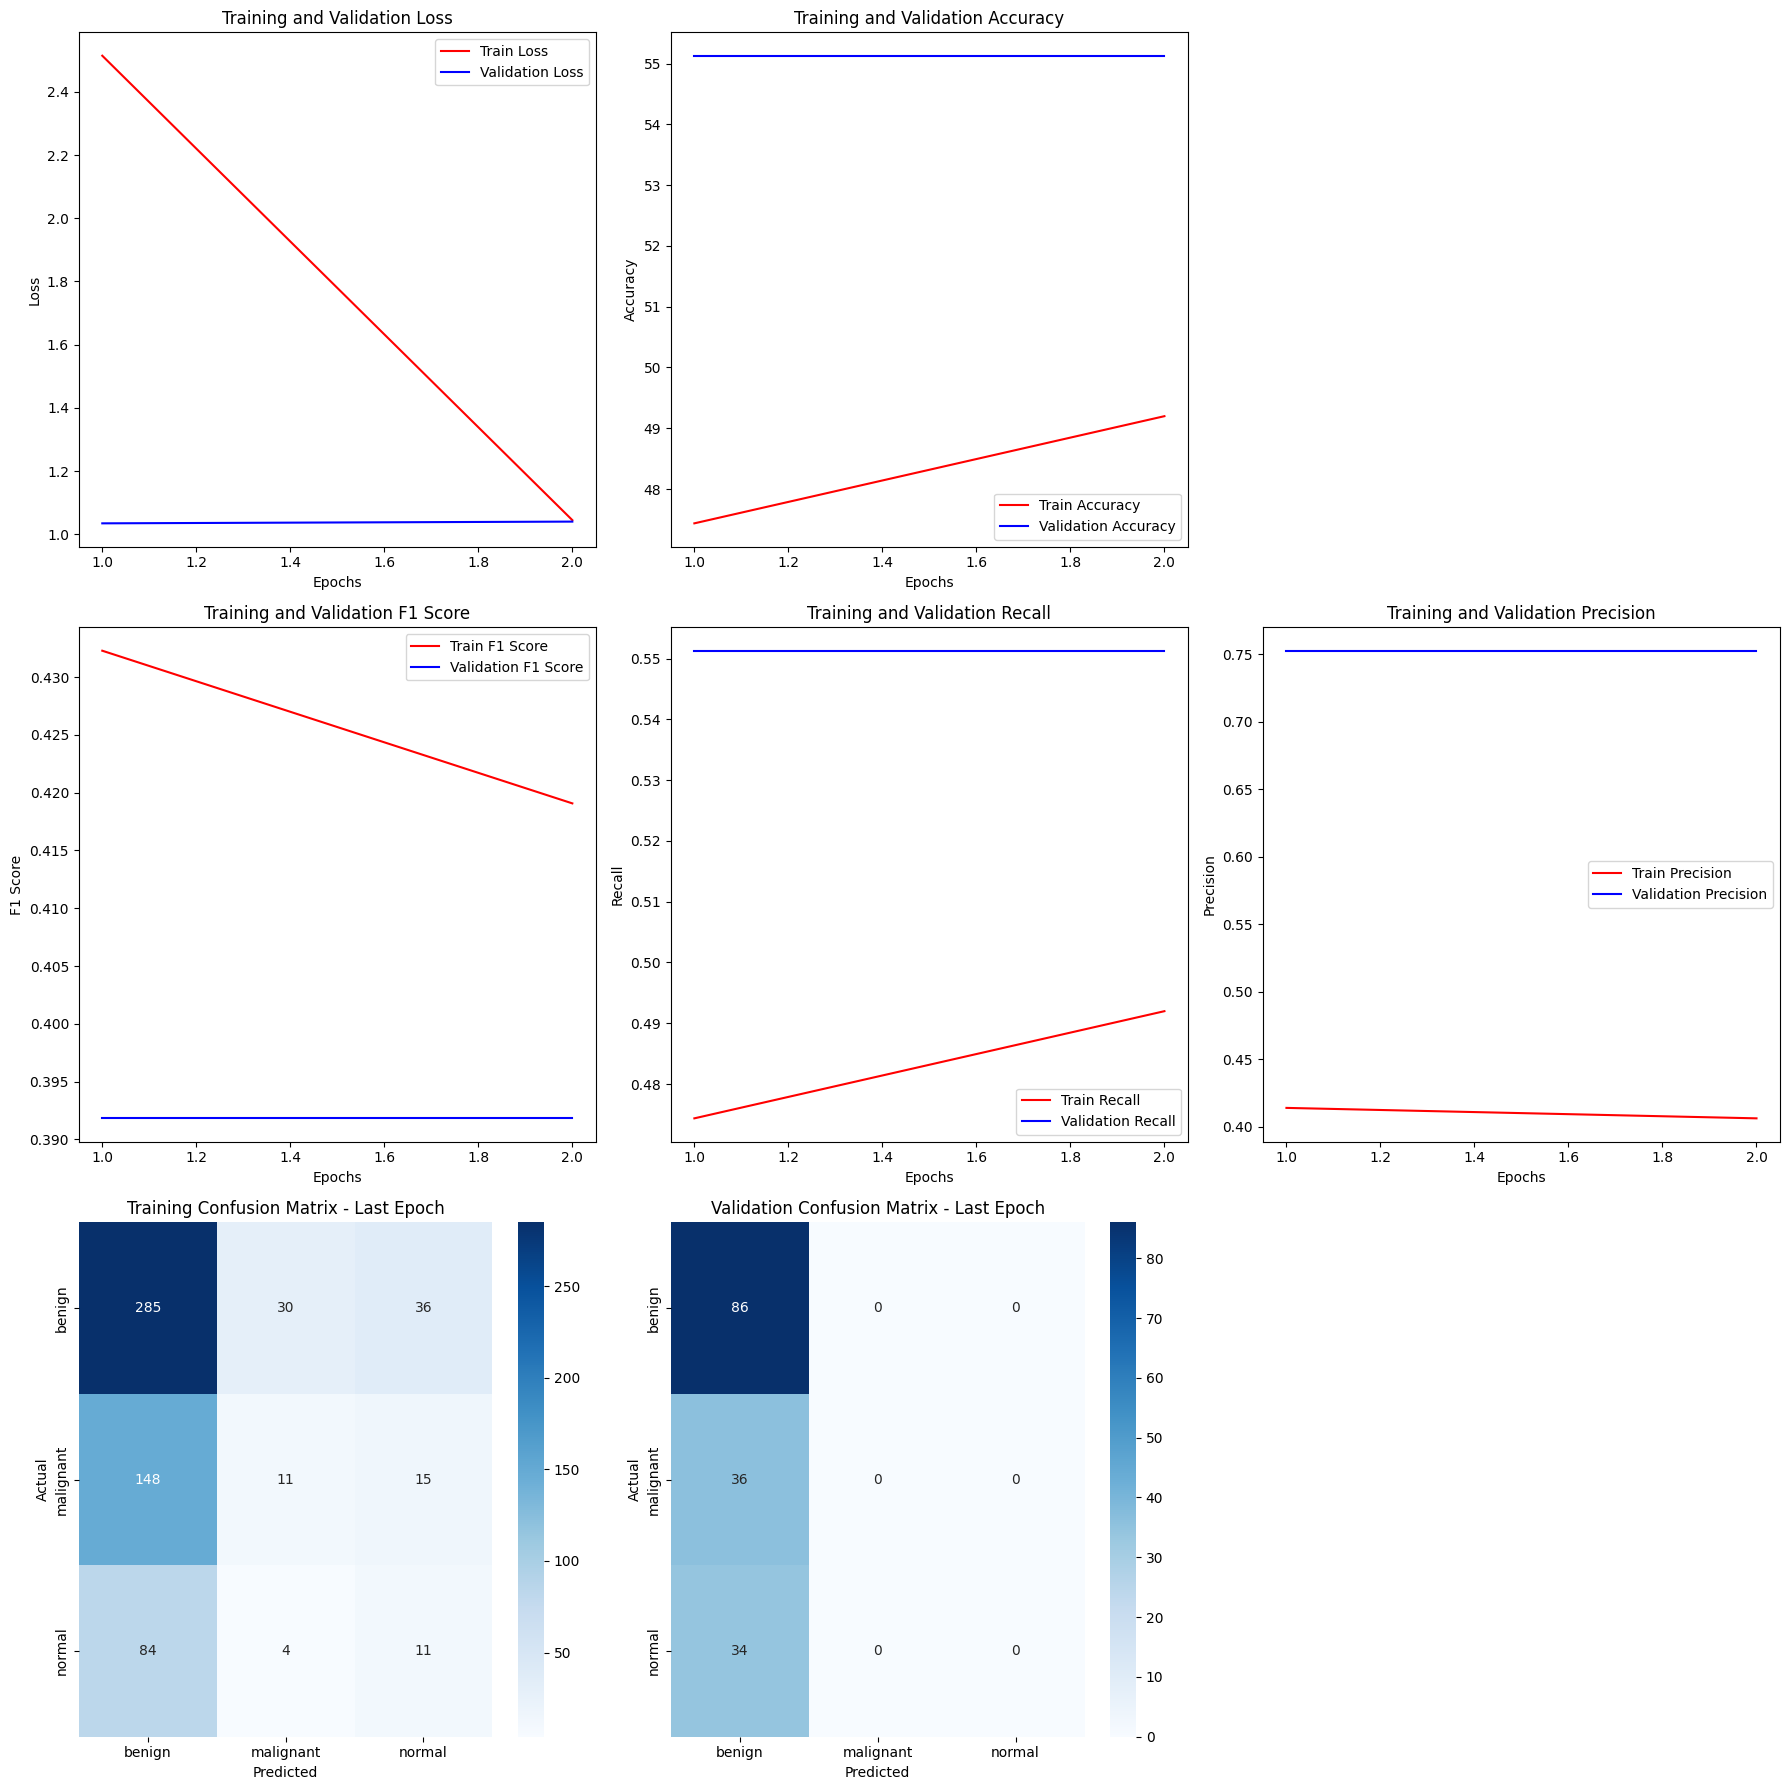

In [52]:
vit_plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores, train_recalls, val_recalls, train_precisions, val_precisions, train_conf_matrices, val_conf_matrices, all_train_labels, all_train_probs, all_val_labels, all_val_probs, train_loader.dataset.dataset.classes)

Actual labels:  benign benign normal benign
Predicted labels:  benign benign benign benign


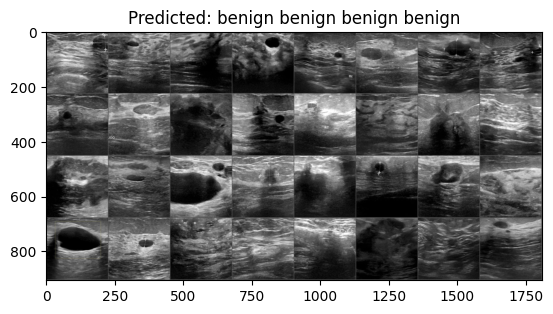

In [53]:
vit_test(model, val_loader, train_loader.dataset.dataset.classes, mean, std)